#### Load libraries needed to run assignment

In [1]:
import cv2
import opencv_jupyter_ui as jcv2
from feat import Detector
from IPython.display import Image
from collections import Counter
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

c:\Users\Usuario\anaconda3\envs\iis\lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


### Exercise 1
Use the Py-Feat detector to analyze every picture in the dataset.

- Create a visualization of each image by overlaying information on top of the original image. You must show the face bounding boxes and the primary expressed emotion. Store the results in an output folder, with each visualization image named the same as the original picture.

- Accumulate all the AU activations provided by Py-Feat for each face in each frame, and save them into a CSV file named . The file must contain a column named containing the name of the image each row corresponds to. It must also contain another column named that acts as a sequential identifier for each face in the image (ie, it goes up 0, 1, 2... for each face found in the same image).

In [3]:
input_folder = "dataset/images/"
output_folder = "../processed/images/"

aus_file = '../processed/aus.csv'
aus_data = []

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

detector = Detector(device="cuda")


for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg")):

        # Read the image
        img_path = os.path.join(input_folder, filename)
        image = cv2.imread(img_path) 
        #plt.imshow(image_rgb)
        
        # Detect faces and emotions
        prediction = detector.detect_image(img_path)

        output_image = image.copy()
        #plt.imshow(output_image)

        for i, (ind,face) in enumerate(prediction.iterrows()):

            # Bounding box coordinates
            x1, y1, w, h, s = map(int, face.faceboxes)
            #print(x1,y1,h,w)

            # Rectangle around the face in color red
            cv2.rectangle(output_image, (x1, y1), (x1+w, y1+h), (0, 0, 255), 2) # we are in BGR so this is red

            # Primary emotion
            emotions = prediction.emotions.loc[i]
            primary_emotion = emotions.idxmax()
            emotion_text = f"{primary_emotion}"
            cv2.putText(output_image, emotion_text, (x1, y1 - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)



            # AUs
            aus = face[prediction.aus.columns]
            au_dict = {"file": filename, "face": i}
            for au_name, au_value in aus.items():
                au_dict[au_name] = au_value

            aus_data.append(au_dict)

        # Save output img
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, output_image)

aus_df = pd.DataFrame(aus_data)
aus_df.to_csv(aus_file, index=False)

c:\Users\Usuario\anaconda3\envs\iis\lib\site-packages\feat\face_detectors\Retinaface\Retinaface_test.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = t

### Exercise 2
Analyze and visualize the extracted features.

- Separate the AU data into the samples coming from the positive condition (valence of the image is positive, as given in ) vs. the negative condition (valence is negative).  

- For each condition (positive vs. negative) and each AU ( AU01, AU02, AU04, ...), calculate the mean value.

- For each AU, calculate the absolute difference between the positive mean and the negative mean (ie , ignoring the sign).

- Sort the AUs from biggest absolute difference of means to smallest absolute difference of means.

- Display the sorted AUs as a graph. Save the graph as .  au_visualization.png

In [4]:
# Read valence
annotations_df = pd.read_csv('dataset/annotations.csv')

aus_df1 = aus_df.copy()
aus_df1['file'] = aus_df['file'].apply(lambda x: x.split('.')[0])  # Remove file extension

# Merge all data in one df
valence = pd.merge(aus_df1, annotations_df, on='file', how='left')

In [5]:
positive_aus = valence[valence['valence']=='positive']
negative_aus = valence[valence['valence']=='negative']

# Mean of AUs
positive_mean = positive_aus.iloc[:,2:-1].mean(axis=0)
negative_mean = negative_aus.iloc[:,2:-1].mean(axis=0)

# Absolute difference of mean of AUs
abs_diff = np.abs(positive_mean - negative_mean)

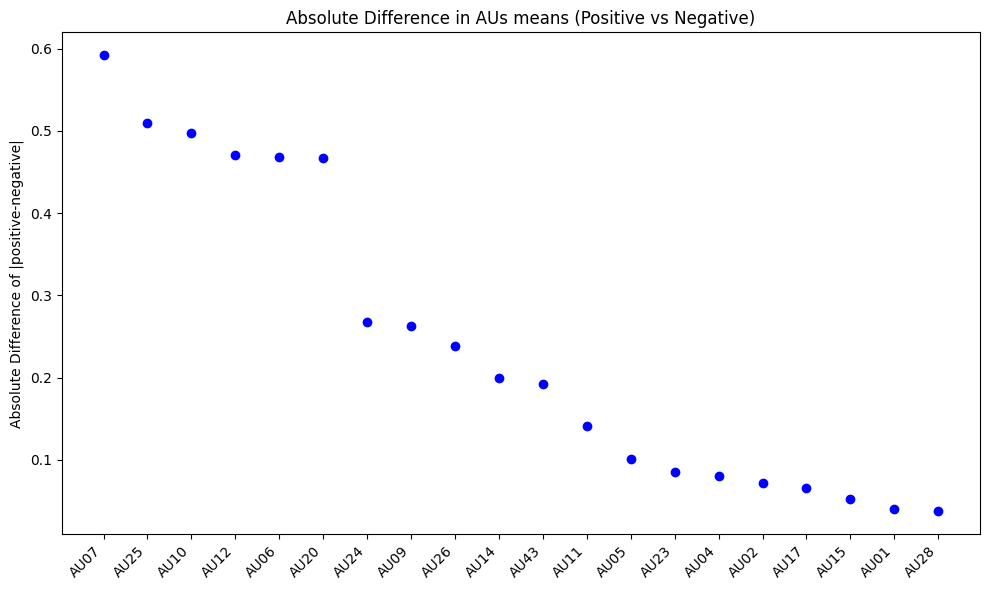

In [6]:
# Sort the AUs
sorted_aus = abs_diff.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_aus.index, sorted_aus.values, marker='o', linestyle = "None", color='b')
plt.ylabel('Absolute Difference of |positive-negative|')
plt.title('Absolute Difference in AUs means (Positive vs Negative)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../processed/au_visualization.png')

# Display the plot
plt.show()